In [1]:
import pandas as pd

df = pd.read_csv('data/flight_dataset_aug_sep.csv')
print(df.shape)
# Convert transit_time to seconds
# Remove any leading/trailing whitespace and newline characters
df['transit_time'] = df['transit_time'].str.strip()

# Convert transit_time to seconds, handling potential errors
df['transit_time'] = pd.to_timedelta(df['transit_time'], errors='coerce').dt.total_seconds()

# Replace NaN values with a placeholder or drop them based on your requirements
df['transit_time'] = df['transit_time'].fillna(-1)  # or use df = df.dropna(subset=['transit_time'])
df['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
df['baroaltitude'] = pd.to_numeric(df['baroaltitude'], errors='coerce')
df['geoaltitude'] = pd.to_numeric(df['geoaltitude'], errors='coerce')
df['vertrate'] = pd.to_numeric(df['vertrate'], errors='coerce')

print(df['transit_time'].dtype)
print(df['transit_time'].head())


df = df[(df['velocity']<=300)&(df['velocity']>100)]
df = df[(df['baroaltitude']<=10000)&(df['baroaltitude']>=4000)]
df = df[(df['vertrate']<=0)&(df['vertrate']>=-20)]
df = df[(df['transit_time']<=3500)&(df['transit_time']>800)] 
df = df.dropna().reset_index(drop=True)  # Drop NaN values and reset index
print(len(df))
print(df.columns)
print(df.hour)  # Display the first few values to verify

(25826, 13)
float64
0    2031.0
1    1519.0
2    1302.0
3    1544.0
4    1168.0
Name: transit_time, dtype: float64
24466
Index(['callsign', 'time', 'icao24', 'lat', 'lon', 'velocity', 'heading',
       'vertrate', 'baroaltitude', 'geoaltitude', 'hour', 'arrival_time',
       'transit_time'],
      dtype='object')
0        2024-09-25 07:00:00+00:00
1        2024-09-25 14:00:00+00:00
2        2024-09-25 08:00:00+00:00
3        2024-09-25 17:00:00+00:00
4        2024-09-25 16:00:00+00:00
                   ...            
24461    2024-09-17 06:00:00+00:00
24462    2024-09-17 18:00:00+00:00
24463    2024-09-17 12:00:00+00:00
24464    2024-09-17 17:00:00+00:00
24465    2024-09-17 16:00:00+00:00
Name: hour, Length: 24466, dtype: object


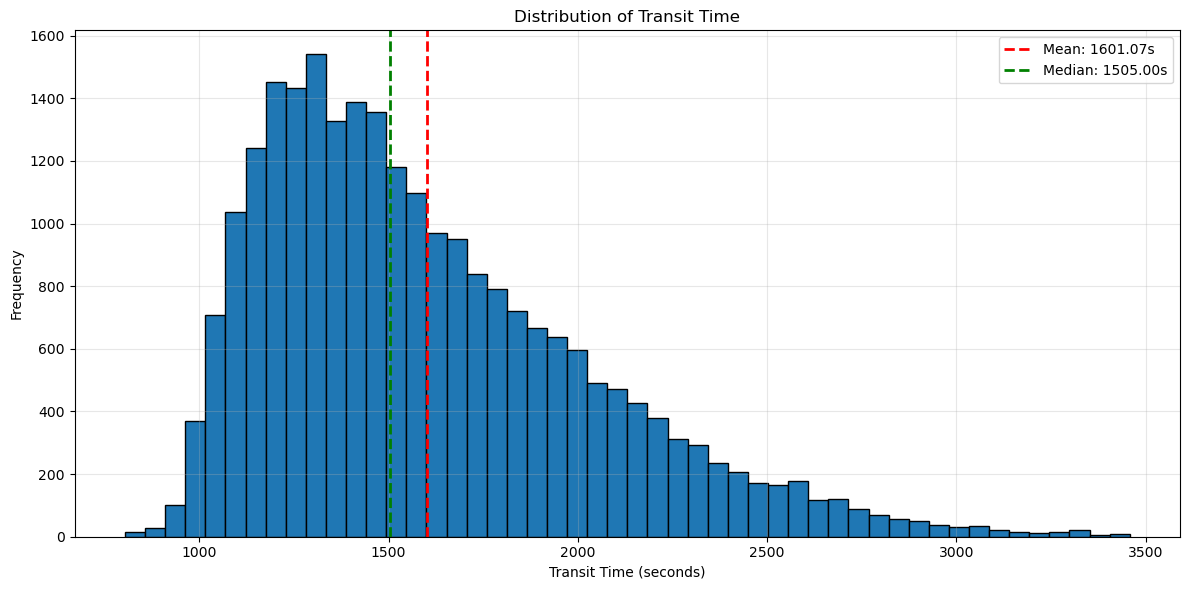

Mean transit time: 1601.07 seconds
Median transit time: 1505.00 seconds
Min transit time: 804.00 seconds
Max transit time: 3458.00 seconds


In [3]:
import matplotlib.pyplot as plt

# Create a histogram of transit_time
plt.figure(figsize=(12, 6))
test = df['transit_time']
plt.hist(test, bins=50, edgecolor='black')
plt.title('Distribution of Transit Time')
plt.xlabel('Transit Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add vertical lines for mean and median
mean_transit = test.mean()
median_transit = test.median()
plt.axvline(mean_transit, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_transit:.2f}s')
plt.axvline(median_transit, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_transit:.2f}s')

plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean transit time: {mean_transit:.2f} seconds")
print(f"Median transit time: {median_transit:.2f} seconds")
print(f"Min transit time: {test.min():.2f} seconds")
print(f"Max transit time: {test.max():.2f} seconds")


In [5]:
# Read the weather score data
weather_df = pd.read_csv('data/EGKK_2024_score.csv')

# Convert datetime columns to datetime type and ensure both are timezone-naive
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_localize(None)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=True).dt.tz_localize(None)

print(weather_df['datetime'].dtype)
print(df['time'].dtype)

# Function to find the closest weather score
def get_closest_weather_score(flight_time):
    # Ensure flight_time is timezone-naive
    flight_time = pd.Timestamp(flight_time).tz_localize(None)
    # Use .loc to avoid SettingWithCopyWarning
    mask = weather_df['datetime'] <= flight_time
    if mask.any():
        closest_time = weather_df.loc[mask, 'datetime'].idxmax()
        return weather_df.loc[closest_time, ['wind_score', 'dangerous_phenom_score', 'precip_score', 'vis_ceiling_score', 'freezing_score']]
    else:
        # Handle case where no weather data is before flight_time
        return pd.Series([None] * 5, index=['wind_score', 'dangerous_phenom_score', 'precip_score', 'vis_ceiling_score', 'freezing_score'])

# Apply the function to each flight
weather_scores = df['time'].apply(get_closest_weather_score)

# Concatenate the weather scores with the original dataframe
df = pd.concat([df, weather_scores], axis=1)

print(df.head())
print(df.columns)


datetime64[ns]
datetime64[ns]
  callsign                time  icao24        lat       lon    velocity  \
0  AEA36UJ 2024-09-25 07:36:05  3453cc  50.163062 -1.576390  201.308057   
1  AEA92UV 2024-09-25 14:52:32  3453cc  50.050778 -1.354807  253.993668   
2   AHY107 2024-09-25 08:25:03  4242f4  51.457261  1.885834  187.757965   
3   AIC145 2024-09-25 17:05:40  800733  51.599199  1.822891  165.342334   
4   AIC169 2024-09-25 16:18:00  8005ef  51.601200  1.820297  171.424135   

              heading  vertrate  baroaltitude  geoaltitude  \
0   26.56505117707799  -7.47776       7421.88      7459.98   
1   26.46125458861053  -8.45312       7261.86      7307.58   
2   281.2175696638928 -10.72896       6073.14      6080.76   
3  239.52541646576842 -10.07872       5455.92      5440.68   
4   239.1247083171026  -5.20192       5844.54      5836.92   

                        hour               arrival_time  transit_time  \
0  2024-09-25 07:00:00+00:00  2024-09-25 08:09:56+00:00        2031.0   


                 time  aircraft_count_1h
0 2024-09-25 07:36:05                 13
1 2024-09-25 14:52:32                 19
2 2024-09-25 08:25:03                 17
3 2024-09-25 17:05:40                 19
4 2024-09-25 16:18:00                 13

Statistics for aircraft count in the previous hour:
count    24466.000000
mean        19.127483
std          5.543929
min          0.000000
25%         16.000000
50%         20.000000
75%         23.000000
max         37.000000
Name: aircraft_count_1h, dtype: float64


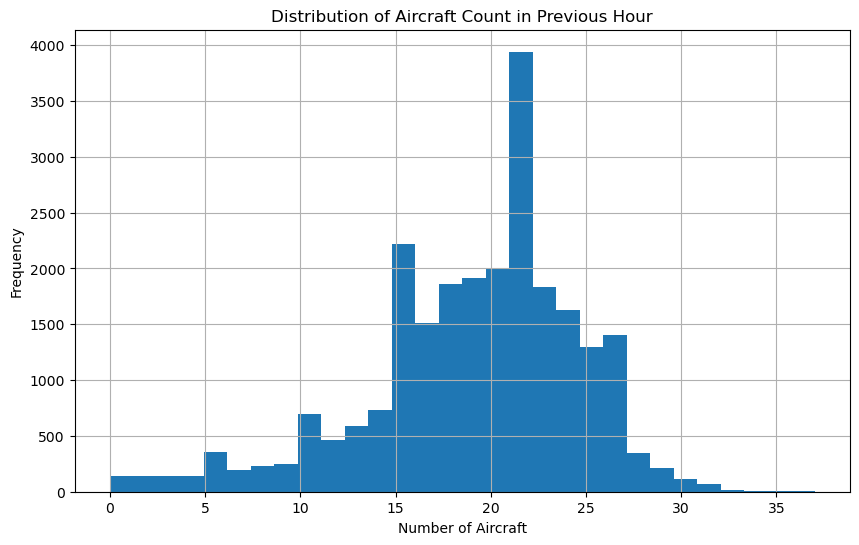

In [6]:
# Create a new column for the number of aircraft entering the airspace 1 hour before
df['aircraft_count_1h'] = df.apply(lambda row: df[(df['time'] >= row['time'] - pd.Timedelta(hours=1)) & 
                                                 (df['time'] < row['time'])].shape[0], axis=1)

# Display the first few rows to verify
print(df[['time', 'aircraft_count_1h']].head())

# Calculate and print some statistics
print("\nStatistics for aircraft count in the previous hour:")
print(df['aircraft_count_1h'].describe())


plt.figure(figsize=(10, 6))
df['aircraft_count_1h'].hist(bins=30)
plt.title('Distribution of Aircraft Count in Previous Hour')
plt.xlabel('Number of Aircraft')
plt.ylabel('Frequency')
plt.show()


In [10]:

# Save the filtered dataframe to a CSV file
df.to_csv('filtered_flight_data_aug_sep.csv', index=False)
print("\nFiltered dataframe saved to 'filtered_flight_data.csv'")



Filtered dataframe saved to 'filtered_flight_data.csv'


In [13]:
df = pd.read_csv('filtered_flight_data_aug_sep.csv')
# Load the aircraft database
aircraft_db = pd.read_csv('data/aircraftDatabase.csv', on_bad_lines='warn', engine='python')
aircraft_db.columns = aircraft_db.columns.str.strip("'")

# Merge the dataframes on icao24
# df = df.merge(aircraft_db[['icao24', 'typecode']], on='icao24', how='left')

# print(df['typecode'])

def identify_wtc(typecode):
    # Load the doc8643AircraftTypes.csv file
    aircraft_types_db = pd.read_csv('data/doc8643AircraftTypes.csv')
    
    # Create a dictionary mapping Designator to WTC
    wtc_dict = dict(zip(aircraft_types_db['Designator'], aircraft_types_db['WTC']))
    
    if pd.isna(typecode):
        return 'M'  # Assign 'M' instead of 'Unknown' for NaN values
    
    typecode = str(typecode).upper()
    
    # Check if the typecode exists in our dictionary
    if typecode in wtc_dict:
        return wtc_dict[typecode]
    else:
        # Manual mapping for specific aircraft types
        jumbo = ['A388']
        heavy = ['A359', 'B788', 'B789', 'B77W', 'B772', 'B763', 'A332', 'A333', 'A339', 'B77L', 'A343', 'A310', 'B752', 'B773', 'B78X']
        medium = ['A320', 'B738', 'A319', 'A21N', 'A20N', 'B38M', 'A321', 'BCS3', 'E190', 'B739', 'E295', 'DH8D', 'E195', 'AT76', 'B39M', 'AT75', 'B737', 'CRJ2', 'E290', 'E145', 'SB91']
        light = ['B06', 'C42', 'DA42', 'C208', 'CL60', 'PC12', 'E35L', 'C68A', 'PA46', 'SPIT', 'CRUZ', 'C152', 'P68', 'GLF6', 'EC35', 'C25M', 'PA34', 'C172']
        
        if typecode in jumbo:
            return 'J'
        elif typecode in heavy:
            return 'H'
        elif typecode in medium:
            return 'M'
        elif typecode in light:
            return 'L'
        else:
            return 'M'  # Assign 'M' if still unknown after manual mapping

# Assign WTC based on typecode
df['wtc'] = df['typecode'].apply(identify_wtc)

# Print WTC distribution
print("\nWake Turbulence Category Distribution:")
print(df['wtc'].value_counts(normalize=True) * 100)

# Print the number of unknown WTC
unknown_count = df['wtc'].value_counts().get('Unknown', 0)
print(f"\nNumber of aircraft with unknown WTC: {unknown_count}")

# Optional: If there are many unknowns, you might want to investigate
if unknown_count > 0:
    print("\nSample of aircraft with unknown WTC:")
    print(df[df['wtc'] == 'Unknown'][['icao24', 'typecode']].sample(min(5, unknown_count)))



Wake Turbulence Category Distribution:
wtc
M    91.339001
H     8.428023
L     0.232976
Name: proportion, dtype: float64

Number of aircraft with unknown WTC: 0


In [14]:
df.to_csv('filtered_flight_data_aug_sep.csv')

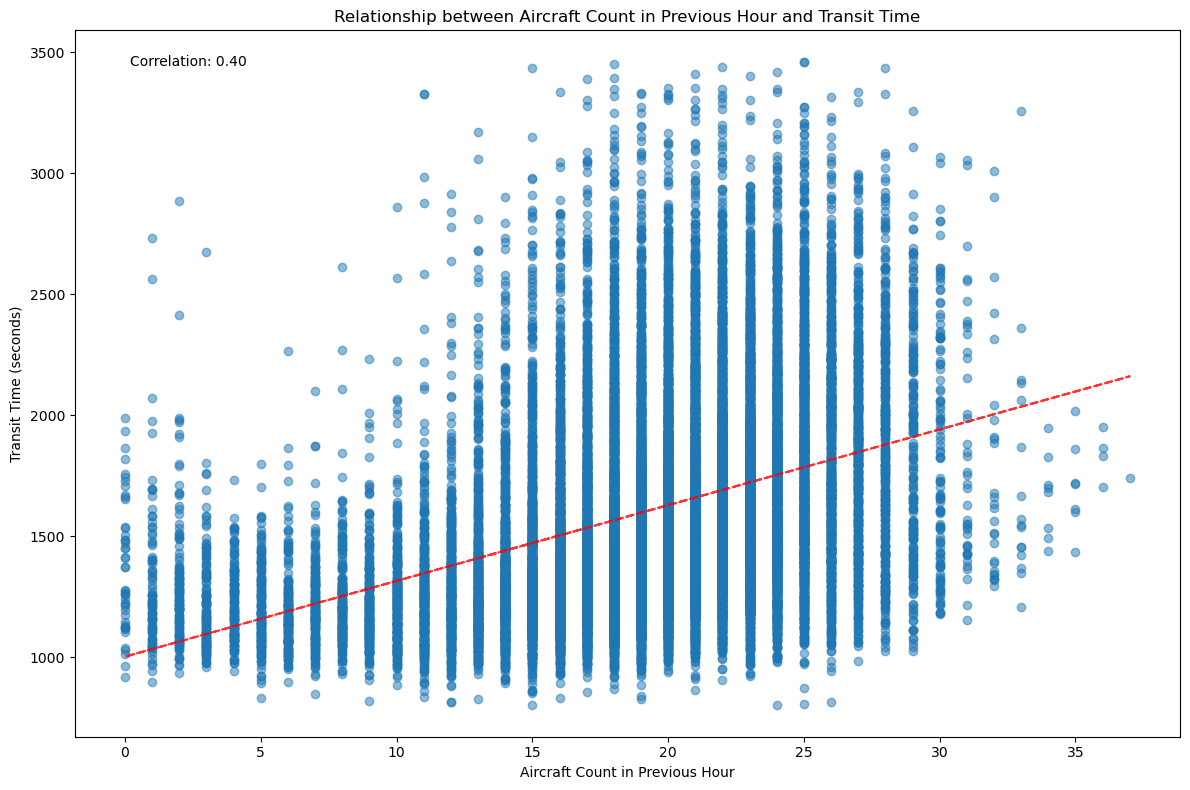

Scatter plot of Aircraft Count in Previous Hour vs Transit Time has been created.


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(df['aircraft_count_1h'], df['transit_time'], alpha=0.5)
plt.title('Relationship between Aircraft Count in Previous Hour and Transit Time')
plt.xlabel('Aircraft Count in Previous Hour')
plt.ylabel('Transit Time (seconds)')

# Add a trend line
z = np.polyfit(df['aircraft_count_1h'], df['transit_time'], 1)
p = np.poly1d(z)
plt.plot(df['aircraft_count_1h'], p(df['aircraft_count_1h']), "r--", alpha=0.8)

# Add correlation coefficient
correlation = df['aircraft_count_1h'].corr(df['transit_time'])
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

print("Scatter plot of Aircraft Count in Previous Hour vs Transit Time has been created.")


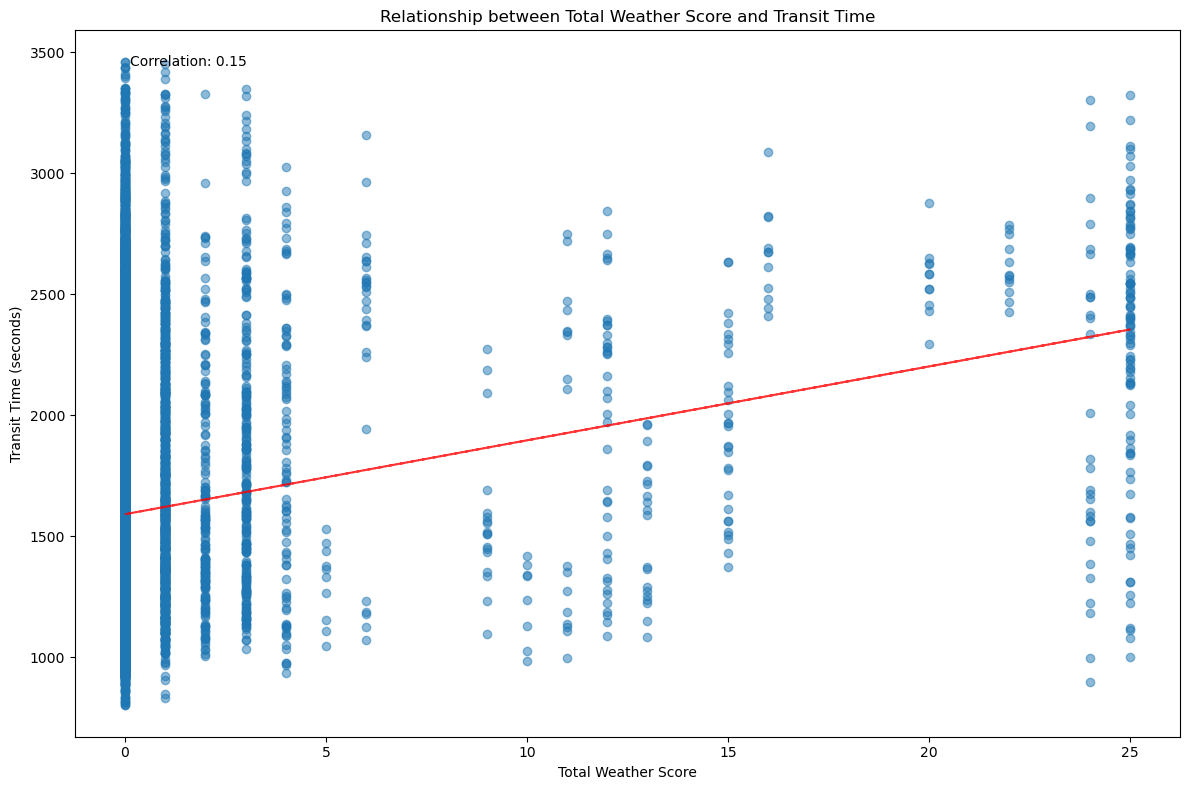

Scatter plot of Total Weather Score vs Transit Time has been created.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate total weather score
df['total_weather_score'] = df['wind_score'] + df['dangerous_phenom_score'] + df['precip_score'] + df['vis_ceiling_score'] + df['freezing_score']

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(df['total_weather_score'], df['transit_time'], alpha=0.5)
plt.title('Relationship between Total Weather Score and Transit Time')
plt.xlabel('Total Weather Score')
plt.ylabel('Transit Time (seconds)')

# Add a trend line
z = np.polyfit(df['total_weather_score'], df['transit_time'], 1)
p = np.poly1d(z)
plt.plot(df['total_weather_score'], p(df['total_weather_score']), "r--", alpha=0.8)

# Add correlation coefficient
correlation = df['total_weather_score'].corr(df['transit_time'])
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

print("Scatter plot of Total Weather Score vs Transit Time has been created.")


Transit Time Statistics for each Callsign:
Expected transit time column has been added based on the mean transit time for each callsign.
  callsign  transit_time  expected_transit_time
0  AEA36UJ        2031.0            1864.644068
1  AEA92UV        1519.0            1799.366667
2   AHY107        1302.0            1546.846154
3   AIC145        1544.0            1808.520000
4   AIC169        1168.0            1684.960000

Summary statistics of the transit time difference:
count    2.446600e+04
mean    -1.189562e-15
std      3.719532e+02
min     -1.030444e+03
25%     -2.525000e+02
50%     -5.953471e+01
75%      1.847089e+02
max      1.913091e+03
Name: transit_time_difference, dtype: float64


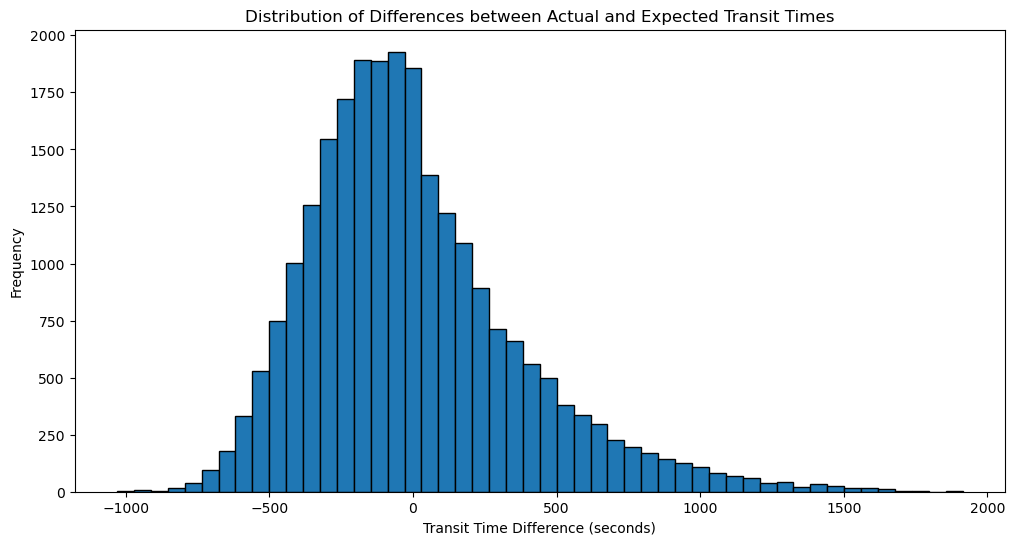

In [17]:

# Group by callsign and calculate transit time statistics
transit_time_stats = df.groupby('callsign')['transit_time'].agg(['count', 'mean', 'std', 'min', 'max'])

# Sort by count in descending order
transit_time_stats = transit_time_stats.sort_values('count', ascending=False)

# Print the statistics
print("Transit Time Statistics for each Callsign:")
transit_time_stats.to_csv('transit_time_stats.csv')

# If you want to limit the output to top N callsigns, uncomment and modify the following line:
# print(transit_time_stats.head(20))  # Print top 20 callsigns
# Calculate expected transit time based on mean transit time for each callsign
callsign_mean_transit = df.groupby('callsign')['transit_time'].mean()
df['expected_transit_time'] = df['callsign'].map(callsign_mean_transit)

print("Expected transit time column has been added based on the mean transit time for each callsign.")

# Display the first few rows to verify the new column
print(df[['callsign', 'transit_time', 'expected_transit_time']].head())

# Calculate the difference between actual and expected transit time
df['transit_time_difference'] = df['transit_time'] - df['expected_transit_time']

print("\nSummary statistics of the transit time difference:")
print(df['transit_time_difference'].describe())

# Visualize the distribution of transit time differences
plt.figure(figsize=(12, 6))
plt.hist(df['transit_time_difference'], bins=50, edgecolor='black')
plt.title('Distribution of Differences between Actual and Expected Transit Times')
plt.xlabel('Transit Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()

df.to_csv('filtered_flight_data_aug_sep.csv')

In [19]:
# Filter out rows where transit time difference equals 0
df_filtered = df[df['transit_time_difference'] != 0]

print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Number of rows removed: {df.shape[0] - df_filtered.shape[0]}")

# # Calculate the percentage of rows removed
# percentage_removed = ((df.shape[0] - df_filtered.shape[0]) / df.shape[0]) * 100
# print(f"Percentage of rows removed: {percentage_removed:.2f}%")

# # Update the original dataframe
# df = df_filtered

# # Recalculate summary statistics of the transit time difference
# print("\nUpdated summary statistics of the transit time difference:")
# print(df['transit_time_difference'].describe())

# # Visualize the updated distribution of transit time differences
# plt.figure(figsize=(12, 6))
# plt.hist(df['transit_time_difference'], bins=50, edgecolor='black')
# plt.title('Updated Distribution of Differences between Actual and Expected Transit Times')
# plt.xlabel('Transit Time Difference (seconds)')
# plt.ylabel('Frequency')
# plt.show()

# # Save the updated dataframe
df.to_csv('filtered_flight_data_aug_sep.csv', index=False)
print("\nUpdated dataset has been saved to 'filtered_flight_data_updated.csv'")


Original dataset shape: (24466, 24)
Filtered dataset shape: (24270, 24)
Number of rows removed: 196

Updated dataset has been saved to 'filtered_flight_data_updated.csv'


Average costs for each wake turbulence category:
  wtc  avg_cost_300  avg_cost_900  avg_cost_1800  avg_cost_3600
0   H        2.2260      3.259333       5.319333      11.186667
1   L        0.1200      0.190000       0.330000       0.750000
2   M        0.7144      1.079600       1.762000       3.673600
3   J        3.3390      4.889000       7.979000      16.780000

Summary statistics of assigned costs:
count    24466.000000
mean         1.017016
std          0.556254
min          0.120000
25%          0.714400
50%          0.714400
75%          1.079600
max          5.319333
Name: cost, dtype: float64


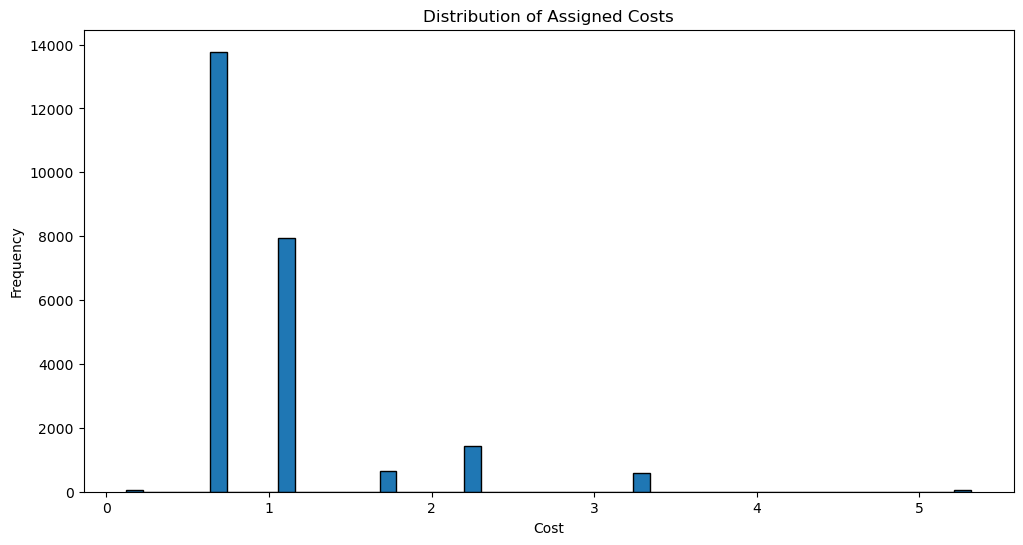


Updated dataset with costs has been saved to 'filtered_flight_data_with_costs.csv'


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('filtered_flight_data_aug_sep.csv')
cost = pd.read_csv('data/alp_19_50.csv')

# Merge the dataframes on the 'category' column
cost['wtc'] = cost['category'].map({'Light': 'L', 'Medium': 'M', 'Heavy': 'H', 'Jumbo': 'J'})

# Compute average costs for each wake turbulence category (wtc)
# Calculate average costs for each wake turbulence category (wtc)
avg_costs = cost.groupby('wtc').agg({
    'cost_300': 'mean',
    'cost_900': 'mean',
    'cost_1800': 'mean',
    'cost_3600': 'mean'
}).reset_index()

# Rename columns for clarity
avg_costs.columns = ['wtc', 'avg_cost_300', 'avg_cost_900', 'avg_cost_1800', 'avg_cost_3600']

# Generate new cost for J (Jumbo) category
# Assuming J should have higher costs than H (Heavy), we'll multiply H costs by a factor
j_factor = 1.5  # Adjust this factor as needed
h_costs = avg_costs[avg_costs['wtc'] == 'H'].iloc[0]
j_costs = h_costs.copy()
j_costs['wtc'] = 'J'
j_costs[['avg_cost_300', 'avg_cost_900', 'avg_cost_1800', 'avg_cost_3600']] *= j_factor

# Add J costs to avg_costs DataFrame
avg_costs = pd.concat([avg_costs, pd.DataFrame([j_costs])], ignore_index=True)

print("Average costs for each wake turbulence category:")
print(avg_costs)
# Merge df with avg_costs based on wtc
df = df.merge(avg_costs, on='wtc', how='left')

# Function to assign cost based on transit time difference and wtc
def assign_cost(row):
    time_diff = abs(row['transit_time_difference'])
    if time_diff <= 300:
        return row['avg_cost_300']
    elif time_diff <= 900:
        return row['avg_cost_900']
    elif time_diff <= 1800:
        return row['avg_cost_1800']
    else:
        return row['avg_cost_3600']

# Apply the function to create a new 'cost' column
df['cost'] = df.apply(assign_cost, axis=1)

# Print summary statistics of the new 'cost' column
print("\nSummary statistics of assigned costs:")
print(df['cost'].describe())

# Optionally, you can visualize the distribution of costs
plt.figure(figsize=(12, 6))
plt.hist(df['cost'], bins=50, edgecolor='black')
plt.title('Distribution of Assigned Costs')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

# Save the updated dataframe with the new 'cost' column
df.to_csv('filtered_flight_data_aug_sep.csv', index=False)
print("\nUpdated dataset with costs has been saved to 'filtered_flight_data_with_costs.csv'")



Total number of flights: 12471
Flights in first three weeks of August: 8468
Flights in last week of August: 4003


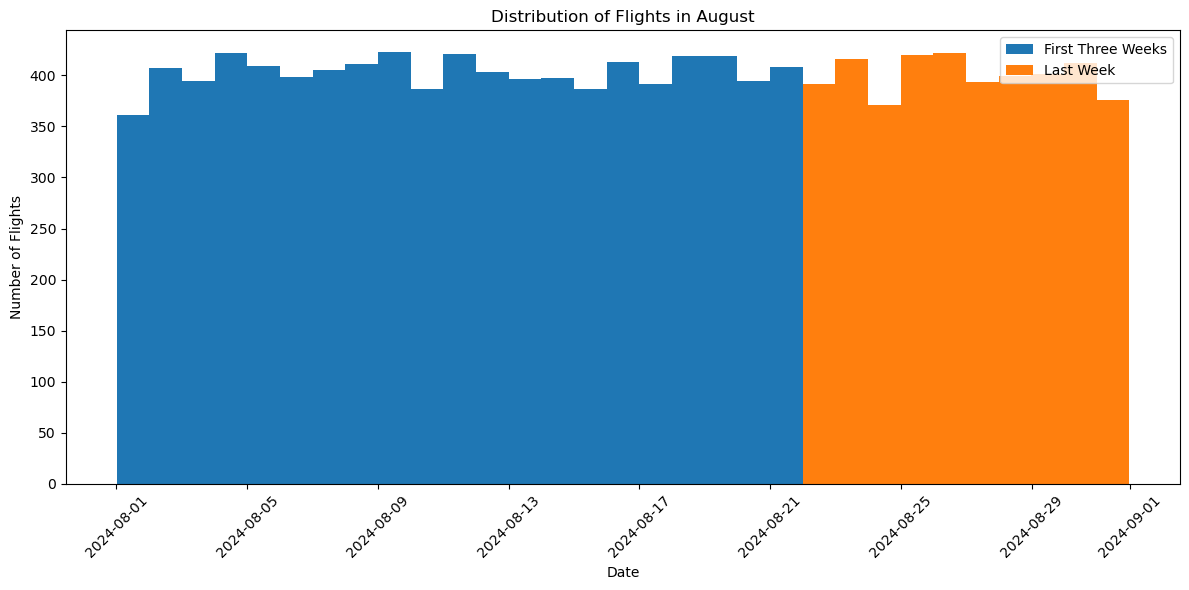

In [19]:
# Convert 'time' column to datetime if it's not already
df['time'] = pd.to_datetime(df['time'])

# Define the split date (end of third week of August)
split_date = pd.to_datetime('2024-08-22')  # Assuming the year is 2024

# Split the dataset
first_three_weeks = df[df['time'] < split_date]
last_week = df[df['time'] >= split_date]

# Print info about the split
print(f"Total number of flights: {len(df)}")
print(f"Flights in first three weeks of August: {len(first_three_weeks)}")
print(f"Flights in last week of August: {len(last_week)}")

# Optionally, save these splits to separate CSV files
first_three_weeks.to_csv('first_three_weeks_august.csv', index=False)
last_week.to_csv('last_week_august.csv', index=False)

# Visualize the distribution of flights
plt.figure(figsize=(12, 6))
plt.hist([first_three_weeks['time'], last_week['time']], 
         label=['First Three Weeks', 'Last Week'],
         bins=31, # One bin per day
         stacked=True)
plt.title('Distribution of Flights in August')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


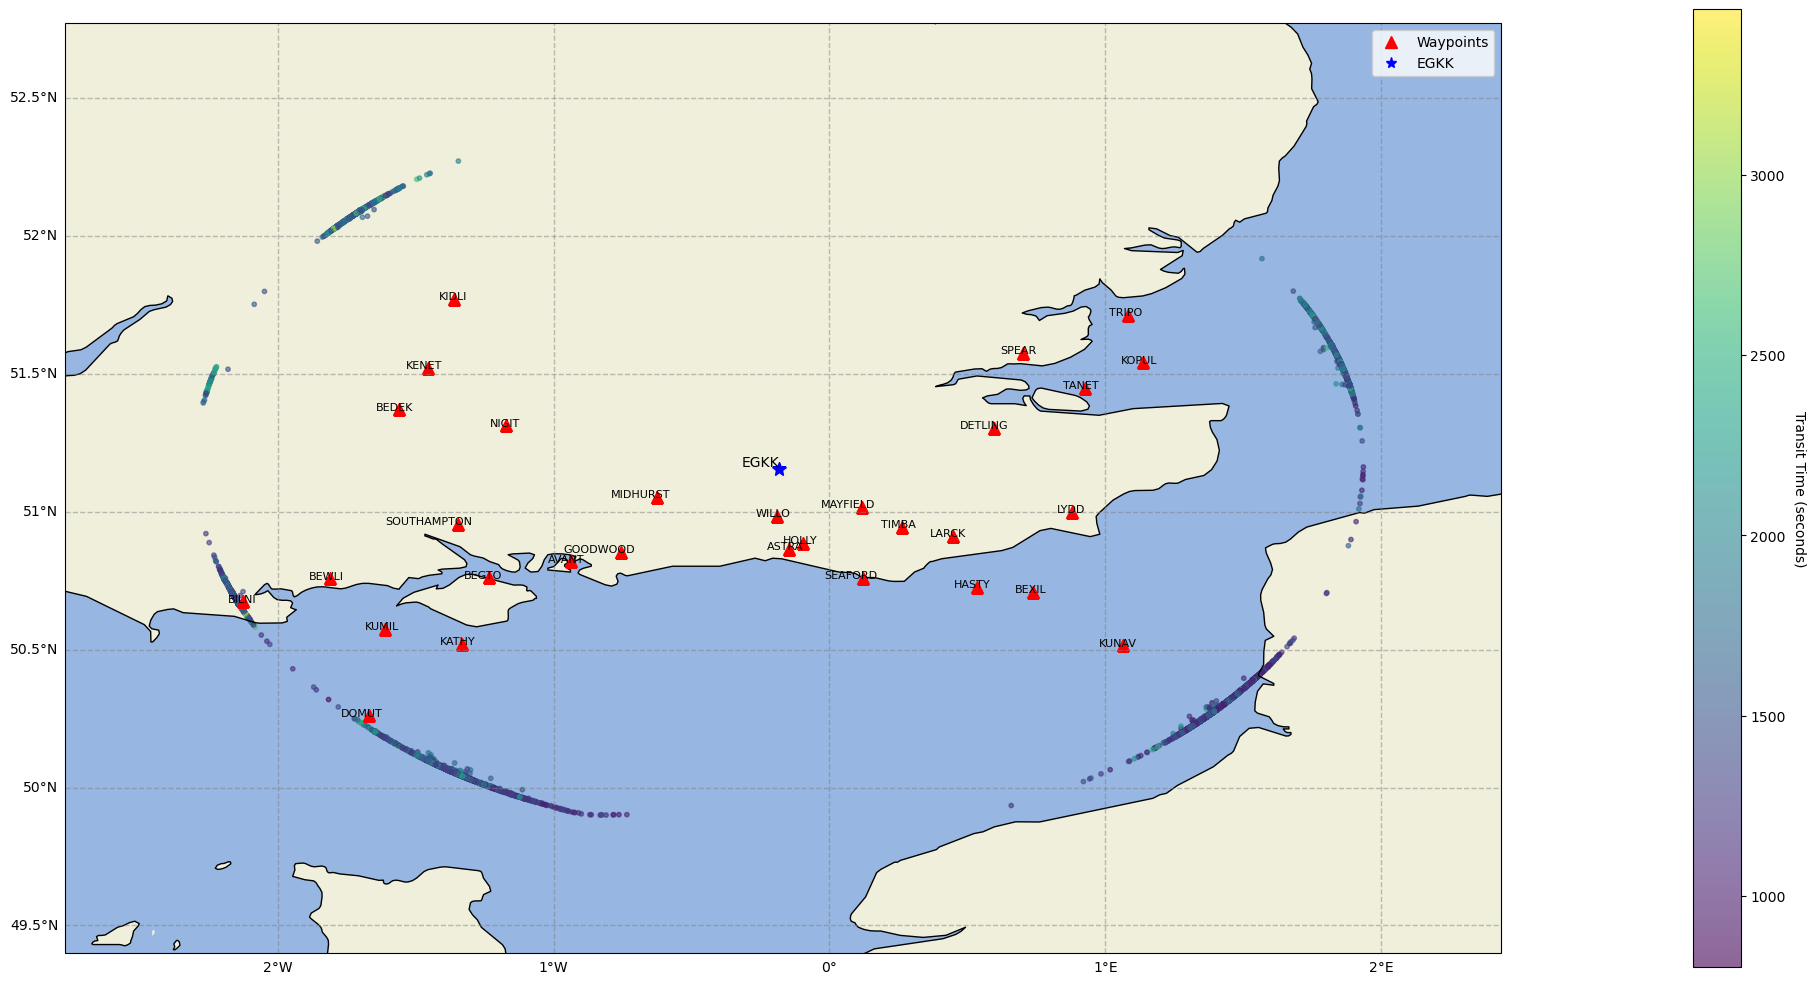

In [64]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd


df = pd.read_csv('filtered_flight_data.csv')

# Create a new figure with a larger size for better visibility
plt.figure(figsize=(20, 10))

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the points
scatter = ax.scatter(df['lon'], df['lat'], c=df['transit_time'], 
                     cmap='viridis', transform=ccrs.PlateCarree(),
                     s=10, alpha=0.6)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Transit Time (seconds)', rotation=270, labelpad=15)
# Read waypoints from CSV file
waypoints_df = pd.read_csv('waypoints.csv')

# Plot waypoints
for _, waypoint in waypoints_df.iterrows():
    ax.plot(waypoint['Longitude'], waypoint['Latitude'], 
            marker='^', markersize=8, color='red', 
            transform=ccrs.PlateCarree())
    ax.text(waypoint['Longitude']+0.05, waypoint['Latitude']-0.01, 
            waypoint['Name'], fontsize=8, 
            ha='right', va='bottom', transform=ccrs.PlateCarree())

# Add legend for waypoints
ax.plot([], [], marker='^', markersize=8, color='red', 
        linestyle='None', label='Waypoints')
ax.plot([], [], marker='*', markersize=8, color='blue', 
        linestyle='None', label='EGKK')
airport_lat, airport_lon = 51.1537, -0.1821

# Visualize the airport
ax.plot(airport_lon, airport_lat, marker='*', markersize=10, color='blue', 
        transform=ccrs.PlateCarree())
ax.text(airport_lon, airport_lat, 'EGKK', fontsize=10, 
        ha='right', va='bottom', transform=ccrs.PlateCarree())
plt.legend()

# Set the map extent to focus on the data
ax.set_global()
ax.set_extent([df['lon'].min()-.5, df['lon'].max()+.5, 
               df['lat'].min()-.5, df['lat'].max()+.5])

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plt.title('Flight Data: Transit Time Visualization')
plt.tight_layout()
plt.show()


In [3]:
from dataset_preparation import haversine_distance

# Define Gatwick Airport coordinates
airport_lat, airport_lon = 51.1537, -0.1821

# Find BILNI and DOMUT waypoints
bilni = waypoints_df[waypoints_df['Name'] == 'BILNI'].iloc[0]
domut = waypoints_df[waypoints_df['Name'] == 'DOMUT'].iloc[0]

# Calculate distances
bilni_distance = haversine_distance(bilni['Latitude'], bilni['Longitude'], airport_lat, airport_lon)
domut_distance = haversine_distance(domut['Latitude'], domut['Longitude'], airport_lat, airport_lon)

print(f"Distance from BILNI to Gatwick Airport: {bilni_distance:.2f} nautical miles")
print(f"Distance from DOMUT to Gatwick Airport: {domut_distance:.2f} nautical miles")


Distance from BILNI to Gatwick Airport: 79.20 nautical miles
Distance from DOMUT to Gatwick Airport: 78.01 nautical miles
